In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.model_selection import train_test_split
from models.mlp import Mlp
from models.dynamic_mlp import dynamic_mlp


In [ ]:
iris = load_iris()
train_x, test_x, train_y, test_y = train_test_split(iris['data'], iris['target'], test_size=0.2, random_state=42)
train_y = np.eye(3)[train_y]
test_y = np.eye(3)[test_y]

mnist_train = pd.read_csv('./data/mnist/mnist_train.csv', header=None)
mnist_test = pd.read_csv('./data/mnist/mnist_test.csv', header=None)

fashion_mnist_train = pd.read_csv('./data/fashion_mnist/fashion_mnist_train.csv', header=None, skiprows=1)
fashion_mnist_test = pd.read_csv('./data/fashion_mnist/fashion_mnist_test.csv', header=None, skiprows=1)

# iris dataset

In [ ]:
input_size = len(iris['data'][0])
output_size = len(np.unique(iris['target']))
hidden_size = 7
print(f"input size: {input_size}, hidden size: {hidden_size}, output size: {output_size}")

network = Mlp(input_size, hidden_size, output_size)
epochs = 3000
learning_rate = 0.0001

train_accuracies = []
test_accuracies = []

for i in range(1):
  loss, accuracy = network.train_mbgd(train_x, train_y, epochs, learning_rate, 5)
  train_accuracies.append(accuracy[-1])
  test_accuracy, _, _ = network.evaluate(test_x, test_y)
  test_accuracies.append(test_accuracy)
  if i == 0:
    plt.plot(accuracy)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy over Epochs')
    plt.show()

avg_train_accuracy = np.mean(train_accuracies)
std_train_accuracy = np.std(train_accuracies)
avg_test_accuracy = np.mean(test_accuracies)
std_test_accuracy = np.std(test_accuracies)

print(f"Average Training Accuracy: {avg_train_accuracy:.2f}% ± {std_train_accuracy:.2f}%")
print(f"Average Testing Accuracy: {avg_test_accuracy:.2f}% ± {std_test_accuracy:.2f}%")

In [ ]:
def render_mnist_predictions(data, predicted, true_number, amount_correct, amount_false, is_fashion=False):
  fashion_list = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  correct_indices = np.where(predicted == true_number)[0]
  false_indices = np.where(predicted != true_number)[0]

  fig, axes = plt.subplots(1, amount_correct, figsize=(15, 3))
  for idx, ax in zip(correct_indices[:amount_correct], axes):
    ax.imshow(data[idx].reshape(28, 28), cmap='gray')
    if is_fashion:
      ax.set_title(f"predicted: {fashion_list[predicted[idx]]}/ {fashion_list[true_number[idx]]}", fontsize=11)
    else:
      ax.set_title(f"Predicted: {predicted[idx]}, True: {true_number[idx]}")
    ax.axis('off')
  plt.suptitle('Predictions')
  plt.show()

  fig, axes = plt.subplots(1, amount_false, figsize=(15, 3))
  for idx, ax in zip(false_indices[:amount_false], axes):
    ax.imshow(data[idx].reshape(28, 28), cmap='gray')
    if is_fashion:
      ax.set_title(f"y_hat: {fashion_list[predicted[idx]]}/ {fashion_list[true_number[idx]]}", fontsize=11)
    else:
      ax.set_title(f"Predicted: {predicted[idx]}, True: {true_number[idx]}")
    ax.axis('off')
  plt.suptitle('Incorrect Predictions')
  plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_mnist(data): 
  X = data.iloc[:, 1:].values.reshape(-1, 28, 28, 1) / 255.0
  y = data.iloc[:, 0].values

  X_augmented = np.empty_like(X)
    
  for i in range(len(X)):
    # beta is for rotation or horizontal shearing
    beta = np.random.uniform(-7.5, 7.5) if y[i] in [1, 7] else np.random.uniform(-15.0, 15.0)

    # gamma is for horizontal and vertical scaling
    gamma = np.random.uniform(15, 20)
    scale_x = np.random.uniform(1 - gamma / 100, 1 + gamma / 100)
    scale_y = np.random.uniform(1 - gamma / 100, 1 + gamma / 100)

    datagen = ImageDataGenerator(
      rotation_range=beta,
      shear_range=np.tan(np.radians(beta)),
      zoom_range=[scale_x, scale_y]
    )

    X_augmented[i] = datagen.random_transform(X[i])

  X_augmented = X_augmented.reshape(-1, 784)
  augmented_data = np.column_stack((y, X_augmented))
  return pd.DataFrame(augmented_data)


In [ ]:
def render_mnist_augmentation(data, augmented_data, amount_images):
  X = data.iloc[:, 1:].values / 255
  y = data.iloc[:, 0].values

  augmented_data = augmented_data.iloc[:, 1:].values / 255

  fig, axes = plt.subplots(2, amount_images, figsize=(15, 6))

  for idx, ax in zip(range(amount_images), axes[0]):
    ax.imshow(X[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f"Original: {y[idx]}")
    ax.axis('off')

  for idx, ax in zip(range(amount_images), axes[1]):
    ax.imshow(augmented_data[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f"Augmented: {y[idx]}")
    ax.axis('off')

  plt.suptitle('Original and Augmented Images')
  plt.show()

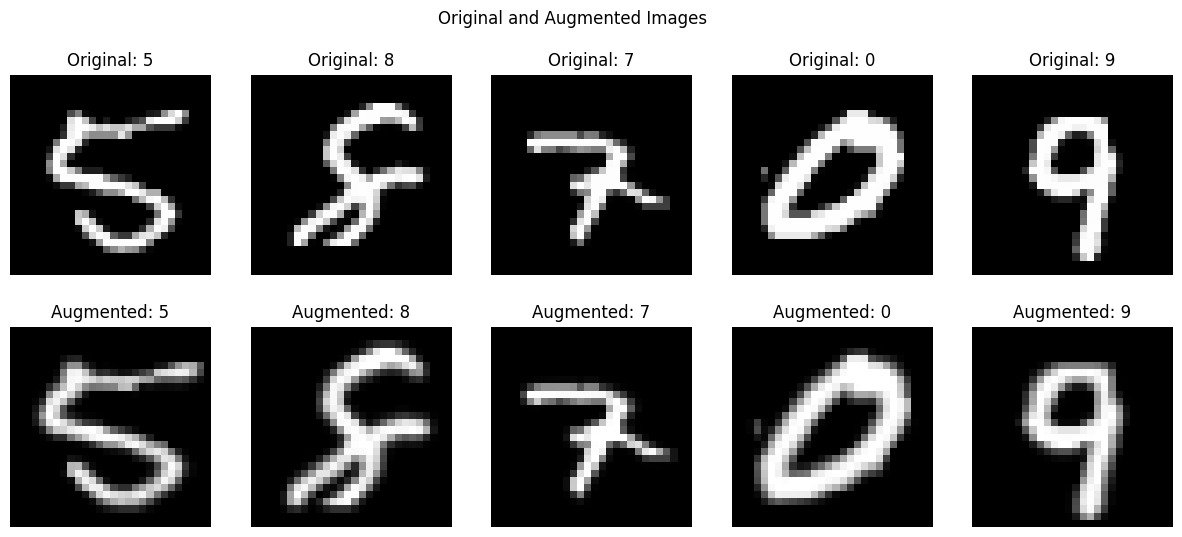

In [74]:
clean_mnist = mnist_train
augmented_mnist = augment_mnist(clean_mnist)
render_mnist_augmentation(clean_mnist.iloc[516:530], augmented_mnist.iloc[516:530], 5)


In [ ]:
mnist_train_x = mnist_train.iloc[:, 1:].values / 255
mnist_train_y = np.eye(10)[mnist_train.iloc[:, 0].values]
mnist_test_x = mnist_test.iloc[:, 1:].values / 255
mnist_test_y = np.eye(10)[mnist_test.iloc[:, 0].values]

network = dynamic_mlp(mnist_train_x, mnist_train_y, mnist_test_x, mnist_test_y, len(mnist_train_x[0]), 1, 1, [700])
network.train(30, 64)

# MNIST dataset

In [ ]:
mnist_train_x = mnist_train.iloc[:, 1:].values / 255
mnist_train_y = np.eye(10)[mnist_train.iloc[:, 0].values]
mnist_test_x = mnist_test.iloc[:, 1:].values / 255
mnist_test_y = np.eye(10)[mnist_test.iloc[:, 0].values]

input_size = len(mnist_train_x[0])
output_size = len(np.unique(mnist_train.iloc[:, 0].values))
hidden_size = input_size // 2
print(f"input size: {input_size}, hidden size: {hidden_size}, output size: {output_size}")

network = Mlp(input_size, hidden_size, output_size)
epochs = 10
learning_rate = 0.01

loss, accuracy = network.train_mbgd(mnist_train_x, mnist_train_y, epochs, learning_rate, 64)
test_accuracy, predicted_class, true_class = network.evaluate(mnist_test_x, mnist_test_y)

print(f"Test accuracy in % {test_accuracy}")
render_mnist_predictions(mnist_test_x, predicted_class, true_class, 5, 5)

# fashion MNIST dataset

In [ ]:
fashion_mnist_train_x = fashion_mnist_train.iloc[:, 1:].values / 255
fashion_mnist_train_y = np.eye(10)[fashion_mnist_train.iloc[:, 0].values]
fashion_mnist_test_x = fashion_mnist_test.iloc[:, 1:].values / 255
fashion_mnist_test_y = np.eye(10)[fashion_mnist_test.iloc[:, 0].values]

input_size = len(fashion_mnist_train_x[0])
output_size = len(np.unique(fashion_mnist_train.iloc[:, 0].values))
hidden_size = input_size // 2
print(f"input size: {input_size}, hidden size: {hidden_size}, output size: {output_size}")

network = Mlp(input_size, hidden_size, output_size)
epochs = 30
learning_rate = 0.001

loss, accuracy = network.train_mbgd(fashion_mnist_train_x, fashion_mnist_train_y, epochs, learning_rate, 64)
test_accuracy, predicted_class, true_class = network.evaluate(fashion_mnist_test_x, fashion_mnist_test_y)

print(f"Test accuracy in % {test_accuracy}")
render_mnist_predictions(fashion_mnist_test_x, predicted_class, true_class, 5, 5, True)


